<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week4_Pet_Adoption_Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INFO 371: Data Mining Applications

## Week 4: Credit Default Decision Tree
### Prof. Charles Dorner, EdD (Candidate)
### College of Computing and Informatics, Drexel University

# Import packages

In [1]:
# 0. Imports ───────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, math, matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score


# Error Rate, Entropy, Gini Index
Measuring the uncertainty of an event with a probability

In [2]:
# 1. Synthetic “Credit‑Default” dataset  (40 customers, 3 features)
np.random.seed(123)
N = 40
df = pd.DataFrame({
    "credit_hist": np.random.choice(["good","average","poor"], N, p=[0.45,0.35,0.20]),
    "income_lvl" : np.random.choice(["low","med","high"],  N, p=[0.35,0.40,0.25]),
    "student"    : np.random.choice(["yes","no"],          N, p=[0.30,0.70]),
})               # will fallback gracefull

In [3]:
# target rule (not linearly separable, keeps tree interesting)
df["default"] = np.where(
        (df.credit_hist=="poor") |
        ((df.income_lvl=="low") & (df.student=="no")),
    "yes", "no"
)
print(df.head())

  credit_hist income_lvl student default
0     average        med      no      no
1        good        low      no     yes
2        good        low      no     yes
3     average        med      no      no
4     average       high      no      no


In [4]:
# 2. Entropy / Gini information‑gain for each attribute
def entropy(series):
    counts = series.value_counts()
    probs  = counts / counts.sum()
    return -(probs*np.log2(probs)).sum()

base_H = entropy(df["default"])
print(f"\nBase entropy = {base_H:.3f} bits")

def gain(col):
    weighted_H = 0
    for _, subset in df.groupby(col):
        weighted_H += len(subset)/len(df) * entropy(subset["default"])
    return base_H - weighted_H

for col in ["credit_hist","income_lvl","student"]:
    print(f"Gain({col:<11}) = {gain(col):.3f} bits")



Base entropy = 0.954 bits
Gain(credit_hist) = 0.320 bits
Gain(income_lvl ) = 0.720 bits
Gain(student    ) = 0.040 bits


In [5]:
# 3. One‑Hot Decision‑Tree pipeline
pipe = Pipeline([
    ("ohe",  OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ("tree", DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=0))
]).fit(df[["credit_hist","income_lvl","student"]], df["default"])

In [6]:
# 4. Evaluation
pred = pipe.predict(df[["credit_hist","income_lvl","student"]])
print("\nResub accuracy:", round(accuracy_score(df["default"], pred),3))



Resub accuracy: 1.0



Tree rules:
 |--- income_lvl_low <= 0.50
|   |--- credit_hist_poor <= 0.50
|   |   |--- class: no
|   |--- credit_hist_poor >  0.50
|   |   |--- class: yes
|--- income_lvl_low >  0.50
|   |--- class: yes



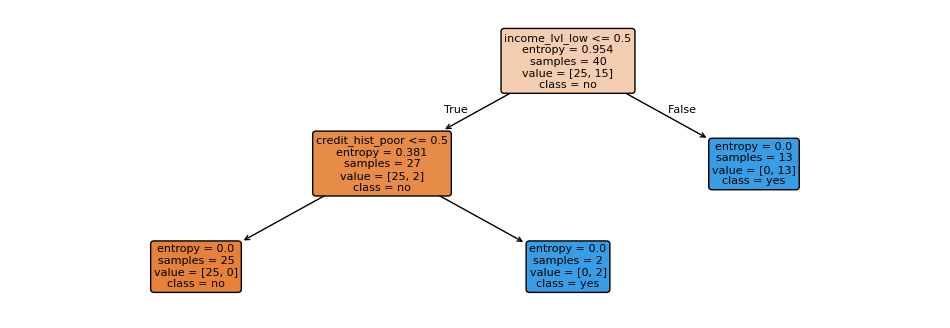

In [8]:
# 5. Rule dump + plot
print("\nTree rules:\n",
      export_text(pipe.named_steps["tree"],
                  feature_names=pipe.named_steps["ohe"].get_feature_names_out()))

plt.figure(figsize=(12,4))
plot_tree(pipe.named_steps["tree"],
          feature_names=pipe.named_steps["ohe"].get_feature_names_out(),
          class_names=["no","yes"],
          filled=True, rounded=True, fontsize=8)
plt.show()
